# Stimulus-Evoked Activity under *in vivo*-like conditions

In [1]:
import numpy as np
from scipy.stats import sem

from cell_template import BRANCH_COLORS
from parallel import Parallel

import sys, os
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

--No graphics will be displayed.


# Protocol Description

- synapses splitted in excitatory (80%) and inhibitory (20%) categories
- background excitatory+inhibitory synaptic events at a given frequency (events through Poisson process)
- stimulus: during a time window $w$ the release frequency of excitatory synapses is increased by $f_{syn}$ to generate events (Poisson process of freq $f_syn$ on top of the background act)
- simulations on a per branch basis -- considering only the synapses of a given branch -- performing simulations on each branch

# Single Simulation Example

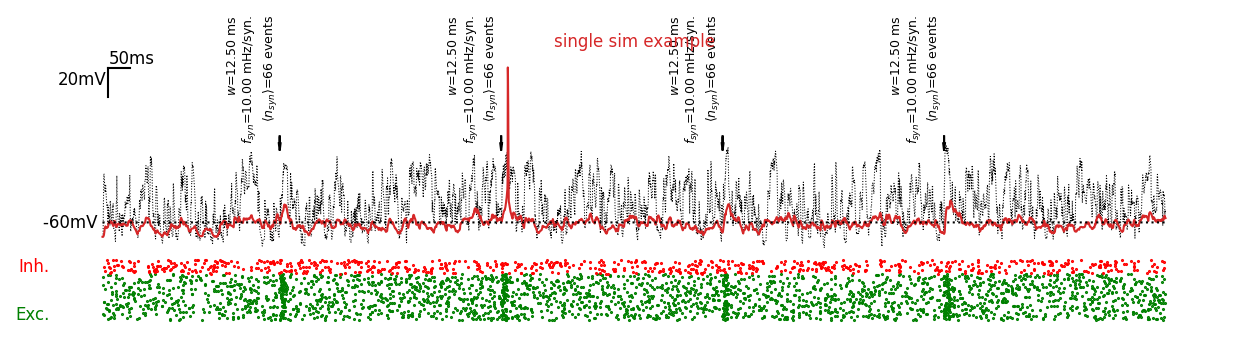

In [92]:
def plot(filename, filenames = [],
         start=0, starts=[],
         length = np.inf,
         title='',
         color='tab:purple'):
    if len(filenames)==0:
        filenames = [filename]
    if len(starts)==0:
        starts= [start for f in filenames]

    fig, AX = pt.figure(axes_extents=[[(1,3)],[(1,1)]],
                        figsize=(3,0.7), left=0, bottom=0., hspace=0.)
    t0 = 0
    for f, filename, start in zip(range(len(starts)), filenames, starts):
        results = np.load(filename, allow_pickle=True).item()
        #print(results)
        t = np.arange(len(results['Vm_soma']))*results['dt']
        cond = (t>=start) & (t<(start+length))
        for r in range(int(results['nStimRepeat'])):
            tstart = results['t0']+r*results['ISI']
            if (tstart>=start) & (tstart<(start+length)):
                pt.arrow(AX[0], [tstart-t[cond][0]+t0, 0, 0, -10],
                         head_width=4, head_length=5, width=0.1)
                w, f = results['width'], 1e3*results['freq']
                ntot = len(results['synapses'])*0.8*results['width']*results['freq']
                pt.annotate(AX[0], (r'$w$=%.2f ms'%w)+'\n'+(r'$f_{syn}$=%.2f mHz/syn.'%f)+'\n'+\
                                   (r'$\langle n_{syn} \rangle $=%i events') % ntot, 
                            (tstart-t[cond][0]+t0, -5), rotation=90, xycoords='data', fontsize=6, ha='right', va='bottom')
        AX[0].plot(t[cond]-t[cond][0]+t0, results['Vm_dend'][cond], 'k:', lw=0.5, label=' distal\ndendrite' if not f else None)
        AX[0].plot(t[cond]-t[cond][0]+t0, results['Vm_soma'][cond], color=color, label='soma' if not f else None)
        AX[0].plot(t[cond]-t[cond][0]+t0, -60+0*t[cond], 'k:')
        for i, events in enumerate(results['presynaptic_exc_events']):
            condE = (events>=start) & (events<(start+length))
            AX[1].plot(events[condE]-t[cond][0]+t0, i*np.ones(len(events))[condE], '.', color='g', ms=1)
        for i, events in enumerate(results['presynaptic_inh_events']):
            condE = (events>=start) & (events<(start+length))
            AX[1].plot(events[condE]-t[cond][0]+t0, len(results['presynaptic_exc_events'])+\
                       i*np.ones(len(events))[condE], '.', 
                       color='r', ms=1)
        t0 += 1.05*length
    pt.annotate(AX[0], '-60mV ', (0,-60), xycoords='data', ha='right', va='center')
    pt.draw_bar_scales(AX[0], Xbar=50, Xbar_label='50ms', Ybar=20, Ybar_label='20mV')
    pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
    pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')
        
    pt.set_common_xlims(AX) #lims=[0, t0])
    for ax in AX:
        ax.axis('off')
            
    AX[0].set_title(title, color=color)
    return fig, AX
plot('../../data/detailed_model/IT-Basket-w12.5ms-f10mHz.npy', title='single sim example', color='tab:red');

## Generating Demo data

see the associated [bash script](./script.sh) for numerical simulations.
Execute the script with the argument:
```
bash script.sh intensity-demo
bash script.sh timing-demo
```

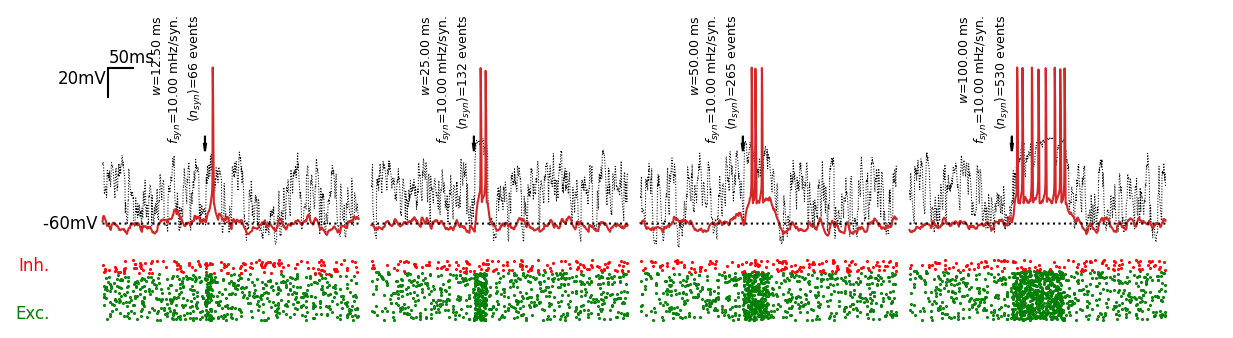

In [93]:
durations = ['12.5', '25', '50', '100']
filenames = ['../../data/detailed_model/IT-Basket-w%sms-f10mHz.npy' % d for d in durations]
fig, _ = plot(None, filenames, starts=[700, 200, 200, 200], length=500, color='tab:red')
fig.savefig('../../figures/detailed_model/intensity-timing-Basket-raw.eps')

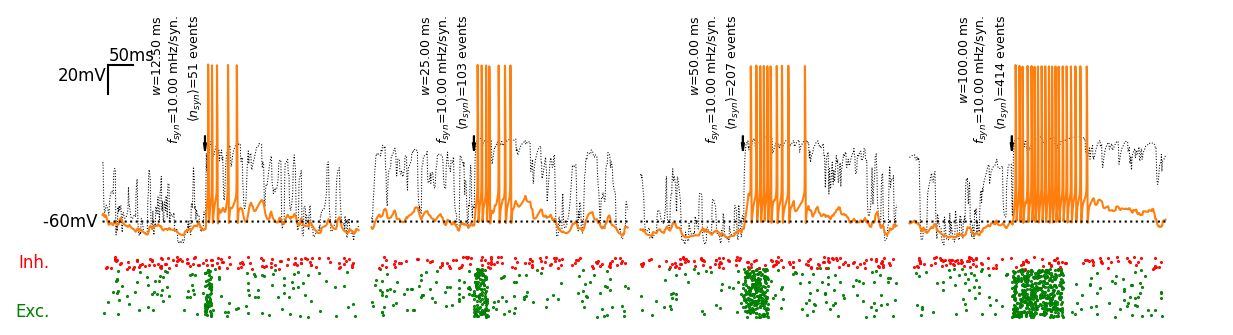

In [94]:
durations = ['12.5', '25', '50', '100']
filenames = ['../../data/detailed_model/IT-Martinotti-w%sms-f10mHz.npy' % d for d in durations]
fig, _ = plot(None, filenames, start=1700, length=500, color='tab:orange')
fig.savefig('../../figures/detailed_model/intensity-timing-Martinotti-raw.eps')

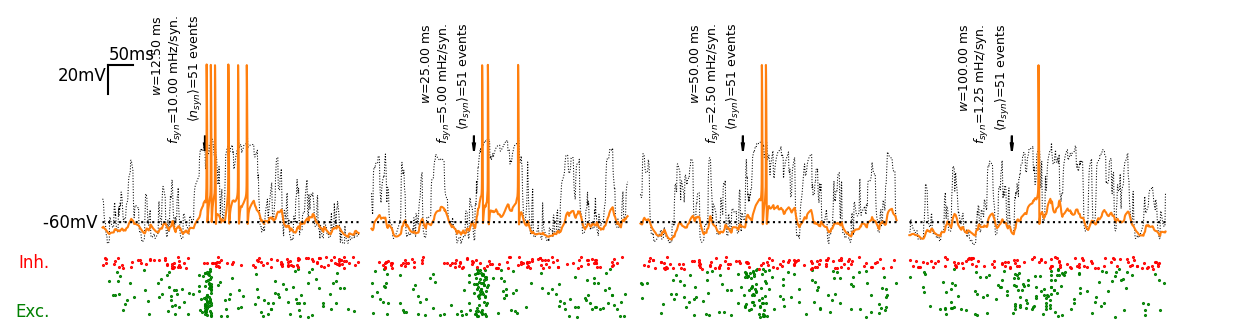

In [214]:
filenames = []
for f in [2, 4, 8, 16]:
    filenames.append('../../data/detailed_model/IT-Martinotti-w%.2fms-f%.2fmHz.npy' % (6.25*f, 20./f))
fig, _ = plot(None, filenames, start=1700, length=500, color='tab:orange')
fig.savefig('../../figures/detailed_model/timing-Martinotti-raw.svg')

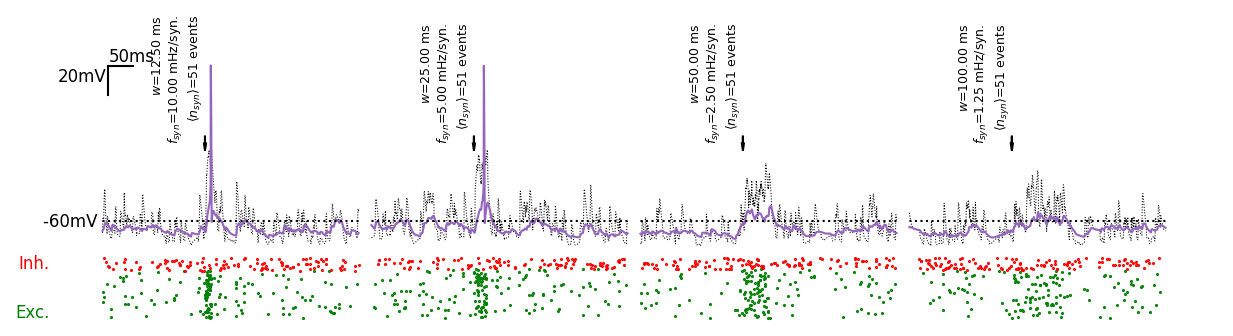

In [96]:
filenames = []
for f in [2, 4, 8, 16]:
    filenames.append('../../data/detailed_model/IT-Martinotti-NO-NMDA-w%.2fms-f%.2fmHz.npy' % (6.25*f, 20./f))
fig, _ = plot(None, filenames, start=700, length=500, color='tab:purple')
fig.savefig('../../figures/detailed_model/timing-Martinotti-NO-NMDA-raw.eps')

# Summary Analysis

- making simulations over different branches
- quantification

### Functions to Load and Analyze the Simulation Data

In [177]:
def load_params_from(sim):
    p = {}
    for k in ['dt', 'nStimRepeat', 'ISI', 't0']:
        p[k] = sim.fetch_quantity_on_grid(k, dtype=float, return_last=True)
    sim.dt = p['dt']
    return p

def extract_trials(sim, 
                   varied_key = 'with_NMDA',
                   true_false_labels=['with-NMDA', 'without'],
                   loc='soma',
                   pre=-30, post=250):
    """
    returns elements of shape:
               VMs     (nBranch, nStims, nStimRepeat, nTimeSamples)
               SPIKES  (nBranch, nStims, nStimRepeat, nTimeSamples)
    """
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    sim.dt = np.unique(p['dt'])[0]
    
    sim.T = np.arange(int(pre/sim.dt), int(post/sim.dt))*sim.dt
    nBranch = len(np.unique(sim.iBranch))
    nFreq = len(np.unique(sim.freq))
    if hasattr(sim, 'broadening'):
        sim.width = sim.width*sim.broadening
    nWidth = len(np.unique(sim.width))
    sim.VMs, sim.SPIKEs, sim.RATEs = {}, {}, {}
    
    for l, label in enumerate(true_false_labels):
        
        sim.VMs[label] = np.zeros((nFreq, nWidth, nBranch, int(p['nStimRepeat']), len(sim.T)))
        sim.SPIKEs[label] = np.zeros((nFreq, nWidth, nBranch, int(p['nStimRepeat']), len(sim.T)), dtype=int)
        sim.RATEs[label] = np.zeros((nFreq, nWidth, nBranch, int(p['nStimRepeat']), len(sim.T)), dtype=float)
        
        for iFreq, freq in enumerate(np.unique(sim.freq)):
            for iWidth, width in enumerate(np.unique(sim.width)):
                for iB, iBranch in enumerate(np.unique(sim.iBranch)):
                    params = {'freq':freq, 'width':width, 'iBranch':iBranch}
                    if varied_key is not None:
                        params[varied_key] = (label==true_false_labels[0])

                    Vm = sim.get('Vm_%s' % loc, params)[0]

                    _, sim.VMs[label][iFreq, iWidth, iB, :, :],\
                        sim.SPIKEs[label][iFreq, iWidth, iB, :, :] = \
                            trial_alignement(Vm, p, pre=pre, post=post)
                    sim.RATEs[label][iFreq, iWidth, iB, :, :] =\
                            1e3*sim.SPIKEs[label][iFreq, iWidth, iB, :, :]/sim.dt
                        
        
def trial_alignement(Vm, p, 
                     spike_threshold=-20,
                     pre=-30, post=250):
    
    t = np.arange(len(Vm))*p['dt']
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    VMs = np.zeros((int(p['nStimRepeat']), len(T)))
    SPIKEs = np.zeros((int(p['nStimRepeat']), len(T)), dtype=int)
    for r in range(int(p['nStimRepeat'])):
        tstart = p['t0']+r*p['ISI']
        cond = t>=(tstart+T[0])
        VMs[r,:] = Vm[cond][:len(T)]
        # count spikes
        iSpks =np.argwhere((VMs[r,:][1:]>=spike_threshold) & (VMs[r,:][:-1]<spike_threshold))
        SPIKEs[r,1:][iSpks] = 1
        
    return T, VMs, SPIKEs

# Responses to various stimulus time windows

### Showing the data analyzed on a single branch

generate the data with:
```
bash script.sh intensity-passive
bash script.sh intensity-active
```

In [97]:
simB = Parallel(\
        filename='../../data/detailed_model/TimingStim_simPassiveExample_Basket.zip')
simB.load()
extract_trials(simB, varied_key=None, true_false_labels=['Basket'], post=350)
simM = Parallel(\
        filename='../../data/detailed_model/TimingStim_simPassiveExample_Martinotti.zip')
simM.load()
extract_trials(simM, varied_key=None, true_false_labels=['Martinotti'], post=250)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


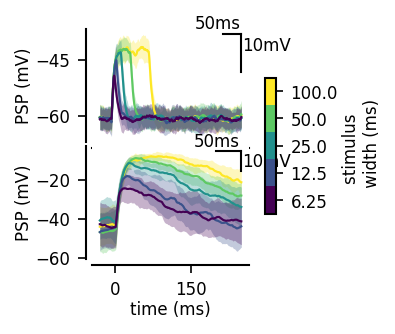

In [99]:
fig, AX = pt.figure(axes=(1,2), figsize=(1.1,1.2), right=10., hspace=0.05)
ba = pt.inset(AX[1], [1.1,0.4,0.07,1.2])

SBSMPL = 10

cmap = plt.cm.viridis
pt.bar_legend(AX[1], ax_colorbar=ba, 
              X=np.arange(len(np.unique(simM.width))), 
              ticks=np.arange(len(np.unique(simM.width))), 
              ticks_labels=['%s'% w for w in np.unique(simB.width)],
              label='stimulus \n width (ms)',
              colormap=cmap)

for sim, label, ax in zip([simB, simM], ['Basket', 'Martinotti'], AX):

    nWidth  = len(np.unique(sim.width))
    for iWidth in np.arange(nWidth)[::-1]:
        Vm = sim.VMs[label][0, iWidth, 0, :, :]
        pt.plot(sim.T[::SBSMPL], np.mean(Vm, axis=0)[::SBSMPL],
                sy=np.std(Vm, axis=0)[::SBSMPL], alpha=0.2,
                color=cmap(iWidth/(len(np.unique(sim.width))-1)), ax=ax)
        ax.plot(sim.T[::SBSMPL], np.mean(Vm, axis=0)[::SBSMPL],
                color=cmap(iWidth/(len(np.unique(sim.width))-1)))
#t.set_common_ylims(AX)
pt.set_plot(AX[0], ylabel='PSP (mV)')
pt.set_plot(AX[1], xlabel='time (ms)', 
            ylabel='PSP (mV)')
pt.draw_bar_scales(AX[0], loc ='top-right', Xbar=50, Xbar_label='50ms', Ybar=10, Ybar_label='10mV')
pt.draw_bar_scales(AX[1], loc ='top-right', Xbar=50, Xbar_label='50ms', Ybar=10, Ybar_label='10mV')
fig.savefig('../../figures/detailed_model/width-variations-psp-responses.eps')

In [142]:
simB = Parallel(\
        filename='../../data/detailed_model/TimingStim_simActiveExample_Basket.zip')
simB.load()
extract_trials(simB, varied_key=None, true_false_labels=['Basket'], post=200)
simM = Parallel(\
        filename='../../data/detailed_model/TimingStim_simActiveExample_Martinotti.zip')
simM.load()
extract_trials(simM, varied_key=None, true_false_labels=['Martinotti'], post=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


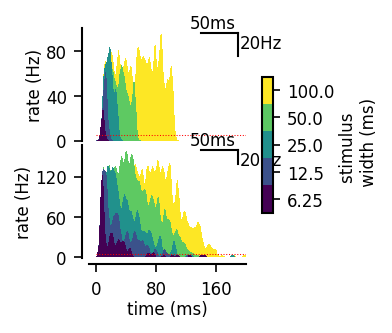

In [144]:
fig, AX = pt.figure(axes=(1,2), figsize=(1.1,1.2), right=10., hspace=0.05)
ba = pt.inset(AX[1], [1.1,0.4,0.07,1.2])

from scipy.ndimage import gaussian_filter1d
SMOOTHING = 2
SUBSMPL = 20
cmap = plt.cm.viridis
pt.bar_legend(AX[1], ax_colorbar=ba, 
              X=np.arange(len(np.unique(simM.width))), 
              ticks=np.arange(len(np.unique(simM.width))), 
              ticks_labels=['%s'% w for w in np.unique(simB.width)],
              label='stimulus \n width (ms)',
              colormap=cmap)

for sim, label, ax in zip([simB, simM], ['Basket', 'Martinotti'], AX):

    nWidth  = len(np.unique(sim.width))
    for iWidth in np.arange(nWidth)[::-1]:
        Rates = gaussian_filter1d(sim.RATEs[label][0, iWidth, 0, :, :].mean(axis=0), int(SMOOTHING/sim.dt))
        ax.bar(sim.T[::SUBSMPL], Rates[::SUBSMPL],
               color=cmap(iWidth/(len(np.unique(sim.width))-1)))
#pt.set_common_ylims(AX)
AX[0].plot([0,200], [5,5], 'r:', lw=0.5)
AX[1].plot([0,200], [5,5], 'r:', lw=0.5)
pt.set_plot(AX[0], ['left'], ylabel='rate (Hz)', xlim=[-10, 200])
pt.set_plot(AX[1], xlabel='time (ms)', ylabel='rate (Hz)', xlim=[-10, 200])
pt.draw_bar_scales(AX[0], loc ='top-right', Xbar=50, Xbar_label='50ms', Ybar=20, Ybar_label='20Hz')
pt.draw_bar_scales(AX[1], loc ='top-right', Xbar=50, Xbar_label='50ms',  Ybar=20, Ybar_label='20Hz')
fig.savefig('../../figures/detailed_model/intensity-spiking-responses.eps')

### Full simulation and summary analysis

generate the data with:
```
bash script.sh window-dep-full
```

In [146]:
simB = Parallel(\
        filename='../../data/detailed_model/TimingStim_simFull_Basket.zip')
simB.load()
extract_trials(simB, varied_key = None, true_false_labels=['real'])
simM = Parallel(\
        filename='../../data/detailed_model/TimingStim_simFull_Martinotti.zip')
simM.load()
extract_trials(simM, varied_key = None, true_false_labels=['with'])

/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_780/2588436856.py:13: RuntimeWarning: invalid value encountered in multiply
  respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


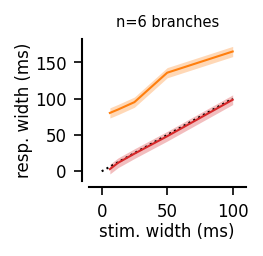

In [148]:
from scipy.stats import sem

def width_plot(sim, freqs, widths, ax,
              label='real', color='k',
              iBranch = 0,
              smoothing=2,
              threshold=5,
               
              cmap = pt.viridis):
    
    # analysis
    nBranch = len(np.unique(sim.iBranch))
    respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf
    for iX, freq in enumerate(freqs):
        iFreq = np.flatnonzero(np.unique(sim.freq)==freq)[0]
        for iY, width in enumerate(widths):
            iWidth = np.flatnonzero(np.unique(sim.width)==width)[0]
            for _, iBranch in enumerate(np.unique(sim.iBranch)):
                rate = gaussian_filter1d(\
                                sim.RATEs[label][iFreq,iWidth,iBranch,:,:].mean(axis=0),# trials
                                int(smoothing/sim.dt))
                up = (sim.T>0) & (rate>threshold) # rate more than threshold
                if np.sum(up)>0:
                    respWidths[iX,iY,iBranch] = sim.T[up][-1]-sim.T[up][0] # first and 

    # plot
    for iX, freq in enumerate(freqs):
        rW = respWidths[iX,:,:]
        pt.plot(widths, np.nanmean(rW, axis=-1),
                sy=sem(rW[np.isfinite(rW)], axis=-1),
                color=color,
                ax=ax, no_set=True)
    
    # bar legend
    #ax.axis('equal')
    ax.set_title('n=6 branches', fontsize=7)

    return fig
    
fig, ax = pt.figure(figsize=(1.1,1.5), right=10.)
ax.plot([0,100], [0,100], 'k:', lw=1)#, alpha=.5)

width_plot(simB, [0.01], np.unique(simB.width), ax,
            color='tab:red', label='real')
width_plot(simM, [0.01], np.unique(simM.width), ax,
            color='tab:orange', label='with')
pt.set_plot(ax, xlim=[-10,110],
            xticks=50*np.arange(3), yticks=50*np.arange(4),
            xlabel='stim. width (ms)',
            ylabel='resp. width (ms)')

fig.savefig('../../figures/detailed_model/width-dep-summary.eps')

# Responses to broadened stimuli

In [178]:
sim = Parallel(\
        filename='../../data/detailed_model/TimingStim_simBroadeningExample_Martinotti.zip')
sim.load()
extract_trials(sim, varied_key = 'with_NMDA', true_false_labels=['with', 'without'])

In [179]:
sim.width

array([[[[[  6.25],
          [ 12.5 ],
          [ 25.  ],
          [ 50.  ],
          [100.  ]]]],



       [[[[  6.25],
          [ 12.5 ],
          [ 25.  ],
          [ 50.  ],
          [100.  ]]]]])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


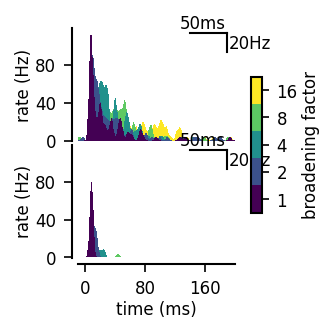

In [181]:
fig, AX = pt.figure(axes=(1,2), figsize=(1.1,1.2), right=10., hspace=0.05)
ba = pt.inset(AX[1], [1.1,0.4,0.07,1.2])

from scipy.ndimage import gaussian_filter1d
SMOOTHING = 2
SUBSMPL = 20
cmap = plt.cm.viridis
pt.bar_legend(AX[1], ax_colorbar=ba, 
              X=np.arange(len(np.unique(sim.broadening))), 
              ticks=np.arange(len(np.unique(sim.broadening))), 
              ticks_labels=['%i'% w for w in np.unique(sim.broadening)],
              label='broadening factor',
              colormap=cmap)

for label, ax in zip(['with', 'without'], AX):

    nWidth  = len(np.unique(sim.width))
    for iWidth in np.arange(nWidth)[::-1]:
        Rates = gaussian_filter1d(sim.RATEs[label][0, iWidth, 0, :, :].mean(axis=0), int(SMOOTHING/sim.dt))
        ax.bar(sim.T[::SUBSMPL], Rates[::SUBSMPL],
               color=cmap(iWidth/(len(np.unique(sim.width))-1)))
        
pt.set_common_ylims(AX)
pt.set_plot(AX[0], ['left'], ylabel='rate (Hz)', xlim=[-10, 200])
pt.set_plot(AX[1], xlabel='time (ms)', ylabel='rate (Hz)', xlim=[-10, 200])
pt.draw_bar_scales(AX[0], loc ='top-right', Xbar=50, Xbar_label='50ms', Ybar=20, Ybar_label='20Hz')
pt.draw_bar_scales(AX[1], loc ='top-right', Xbar=50, Xbar_label='50ms',  Ybar=20, Ybar_label='20Hz')
fig.savefig('../../figures/detailed_model/broadening-spiking-responses.eps')

In [ ]:
sim = Parallel(\
        filename='../../data/detailed_model/TimingStim_simBroadeningFull_Martinotti.zip')
sim.load()
extract_trials(sim, varied_key = 'with_NMDA', true_false_labels=['with', 'without'])

/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_780/1176357659.py:13: RuntimeWarning: invalid value encountered in multiply
  resp = np.zeros((len(widths), nBranch))*np.inf
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


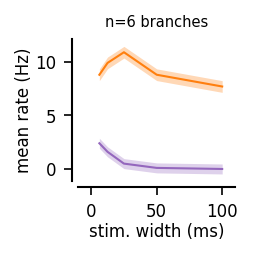

In [206]:
from scipy.stats import sem

def width_plot(sim, widths, ax,
              label='real', color='k',
              iBranch = 0,
              smoothing=2,
              threshold=5,
               
              cmap = pt.viridis):
    
    # analysis
    nBranch = len(np.unique(sim.iBranch))
    resp = np.zeros((len(widths), nBranch))*np.inf
    for iY, width in enumerate(widths):
        iWidth = np.flatnonzero(np.unique(sim.width)==width)[0]
        for iBranch, _ in enumerate(np.unique(sim.iBranch)):
            rate = gaussian_filter1d(\
                            sim.RATEs[label][0,iWidth,iBranch,:,:].mean(axis=0),# trials
                            int(smoothing/sim.dt))
            cond = (sim.T>0) & (sim.T<200) # in the stimulus (+post) window
            resp[iY,iBranch] = np.mean(rate[cond])

    pt.plot(widths, np.nanmean(resp, axis=-1),
            sy=sem(resp[np.isfinite(resp)], axis=-1),
            color=color,
            ax=ax, no_set=True)
    
    ax.set_title('n=6 branches', fontsize=7)

    return fig
    
fig, ax = pt.figure(figsize=(1.1,1.5), right=10.)

width_plot(sim, np.unique(sim.width), ax,
            color='tab:orange', label='with')
width_plot(sim, np.unique(sim.width), ax,
            color='tab:purple', label='without')
pt.set_plot(ax, xlim=[-10,110],
            xticks=50*np.arange(3), #yticks=50*np.arange(4),
            xlabel='stim. width (ms)',
            ylabel='mean rate (Hz)')

fig.savefig('../../figures/detailed_model/width-dep-summary.eps')

# [[ Other ... ]]

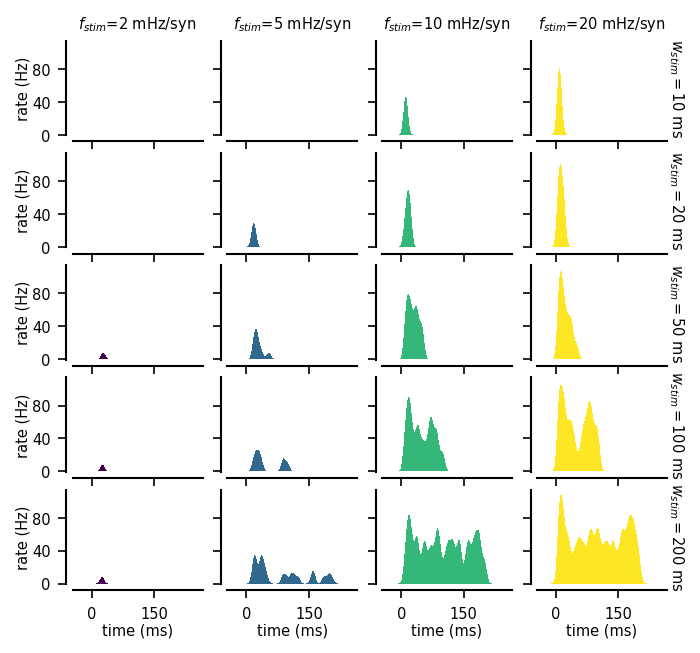

In [142]:
fig = psth_fig(simB, np.unique(simB.freq)[:-1], np.unique(simB.width)[1:],
               label='real',
               smoothing=5,
               iBranch=1)
#fig.savefig('../../figures/detailed_model/intensity-timing-Basket-psth.svg')
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '1.svg'))

In [135]:
from scipy.ndimage import gaussian_filter1d

def psth_fig(sim, freqs, widths,
             label='real',
             smoothing=5, 
             iBranch = 0,
             cmap = pt.viridis):
    
    fig, AX = pt.figure(axes=(len(freqs), len(widths)),
                        figsize=(1,1), hspace=0.3, wspace=0.3)
    iSmooth = int(smoothing/sim.dt)
    iSbsmpl = 10 # int(iSmooth/2)
    
    for iX, freq in enumerate(freqs):
        iFreq = np.flatnonzero(np.unique(sim.freq)==freq)[0]
        for iY, width in enumerate(widths):
            iWidth = np.flatnonzero(np.unique(sim.width)==width)[0]
            AX[iY][iX].bar(sim.T[::iSbsmpl], 
                           gaussian_filter1d(sim.RATEs[label][iFreq,iWidth,iBranch,:,:].mean(axis=0), iSmooth)[::iSbsmpl],
                           color=cmap(iX/(len(freqs)-1)))
            pt.set_plot(AX[iY][iX],
                        title='$f_{stim}$=%i mHz/syn' % (1e3*freq) if not iY else '',
                        xticks_labels=None if iY==(len(widths)-1)  else [],
                        xlabel='time (ms)' if iY==(len(widths)-1) else'',
                        ylabel='rate (Hz)' if iX==0 else'',
                        yticks_labels=None if iX==0 else [],
                        fontsize=7)
            if iX==(len(freqs)-1):
                pt.annotate(AX[iY][iX], '$w_{stim}=%i$ ms' % width, (1, 0.5), va='center', rotation=270, fontsize=7)
    
    pt.set_common_ylims(AX)
    pt.set_common_xlims(AX)
    return fig

In [ ]:
fig = psth_fig(simM, np.unique(simM.freq)[:-1], np.unique(simM.width)[1:],
               iBranch=1,
               label='with-NMDA')
#fig.savefig('../../figures/detailed_model/intensity-timing-Martinotti-psth.svg')
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '2.svg'))

Text(0.5, 1.0, 'n=6 branches')

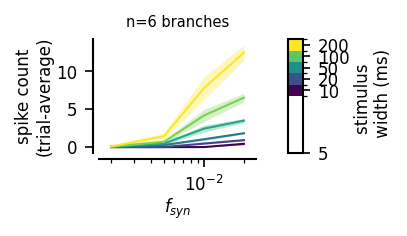

In [41]:
fig, ax = pt.figure(figsize=(1.1,1.2), right=10.)
ba = pt.inset(ax, [1.2,0,0.1,1])

cmap = plt.cm.viridis
pt.bar_legend(ax, ax_colorbar=ba, 
              X=np.arange(len(np.unique(sim.width))), 
              ticks=np.arange(len(np.unique(sim.width))), 
              ticks_labels=['%s'% w for w in np.unique(sim.width)],
              label='stimulus \n width (ms)',
              colormap=cmap)

label='real'
x = np.unique(sim.freq)
for iWidth, width in enumerate(np.unique(sim.width)):
    spike_count = SPIKEs[label][:,iWidth,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
    pt.plot(x[:-1], np.mean(spike_count, axis=-1)[:-1],
            sy=sem(spike_count, axis=-1)[:-1],
            color=cmap(iWidth/(len(np.unique(sim.width))-1)), ax=ax)
            
pt.set_plot(ax, xlabel='$f_{syn}$', xscale='log',
            #yticks=[0,0.5,1],
            #xticks=[0, 20, 40], #xticks_labels=['5', '', '25', '', '45'],
            ylabel='spike count\n(trial-average)')
ax.set_title('n=6 branches', fontsize=7)
#fig.savefig('../../figures/detailed_model/spiking-responses-Basket.eps')
#fig.savefig('../../figures/detailed_model/spiking-responses-Basket.svg')

/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/879535251.py:12: RuntimeWarning: invalid value encountered in multiply
  respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf


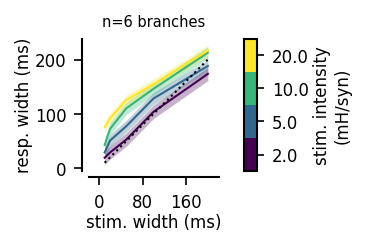

In [155]:
from scipy.stats import sem

def width_fig(sim, freqs, widths,
              label='real',
              iBranch = 0,
              smoothing=5,
              threshold=10,
              cmap = pt.viridis):
    
    # analysis
    nBranch = len(np.unique(sim.iBranch))
    respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf
    for iX, freq in enumerate(freqs):
        iFreq = np.flatnonzero(np.unique(sim.freq)==freq)[0]
        for iY, width in enumerate(widths):
            iWidth = np.flatnonzero(np.unique(sim.width)==width)[0]
            for _, iBranch in enumerate(np.unique(sim.iBranch)):
                rate = gaussian_filter1d(\
                                sim.RATEs[label][iFreq,iWidth,iBranch,:,:].mean(axis=0),# trials
                                int(smoothing/sim.dt))
                up = (sim.T>0) & (rate>threshold) # rate more than threshold
                if np.sum(up)>0:
                    respWidths[iX,iY,iBranch] = sim.T[up][-1]-sim.T[up][0] # first and 

    # plot
    fig, ax = pt.figure(figsize=(1.,1.4), right=10.)
    for iX, freq in enumerate(freqs):
        rW = respWidths[iX,:,:]
        pt.plot(widths, np.nanmean(rW, axis=-1),
                sy=sem(rW[np.isfinite(rW)], axis=-1),
                color=cmap(iX/(len(freqs)-1)), ax=ax, no_set=True)
    ax.plot(widths, widths, 'k:', lw=1)#, alpha=.5)
    # bar legend
        
    ba = pt.inset(ax, [1.2,0,0.1,1])
    pt.bar_legend(ax, ax_colorbar=ba, 
                      X=np.arange(len(freqs)), 
                      ticks=np.arange(len(freqs)), 
                      ticks_labels=['%s'% (1e3*w) for w in np.unique(freqs)],
                      label='stim. intensity\n(mH/syn)',
                      colormap=cmap)

    ax.axis('equal')
    pt.set_plot(ax, 
                xlim=[0, widths[-1]],
                xlabel='stim. width (ms)',
                ylabel='resp. width (ms)')
    ax.set_title('n=6 branches', fontsize=7)

    return fig

fig = width_fig(simM, np.unique(simM.freq)[:-1], np.unique(simM.width)[1:],
               label='with-NMDA')


fig.savefig('../../figures/detailed_model/intensity-timing-Martinotti-width.svg')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '4.svg'))

/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/879535251.py:12: RuntimeWarning: invalid value encountered in multiply
  respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf
/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/879535251.py:29: RuntimeWarning: Mean of empty slice
  pt.plot(widths, np.nanmean(rW, axis=-1),
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


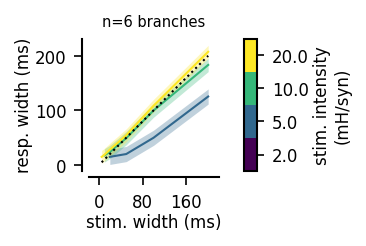

In [154]:
fig = width_fig(simB, np.unique(simM.freq)[:-1], np.unique(simM.width),
               label='real')
fig.savefig('../../figures/detailed_model/intensity-timing-Basket-width.svg')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '3.svg'))

/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/1924566592.py:12: RuntimeWarning: invalid value encountered in multiply
  respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf
/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/1924566592.py:29: RuntimeWarning: Mean of empty slice
  pt.plot(widths, np.nanmean(rW, axis=-1),
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


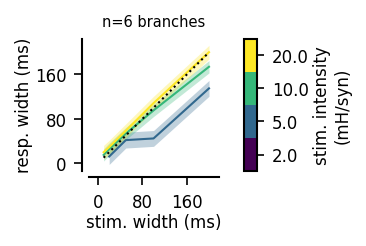

In [135]:
fig = width_fig(simM, np.unique(simM.freq)[:-1], np.unique(simM.width)[1:],
               label='without')